## Summary of the Experiment: 

## Mount the drive

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting the correct path 

In [ ]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'deep_ensemble'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/


## Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K
#from keras_uncertainty.losses import regression_gaussian_nll_loss, regression_gaussian_beta_nll_loss
#from keras_uncertainty.metrics import gaussian_interval_score

#tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(tf.executing_eagerly())

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.0
True


## Deep Ensemble

In [ ]:
import keras 
METADATA_FILENAME = "metadata.yml"

class DeepEnsemble:
    def __init__(self, model_fn=None, num_estimators=None, models=None, needs_test_estimators=False):
        self.needs_test_estimators = needs_test_estimators

        if models is None:
            assert model_fn is not None and num_estimators is not None
            assert num_estimators > 0
            
            self.num_estimators = num_estimators
            self.train_estimators = [None] * num_estimators 
            self.test_estimators = [None] * num_estimators

            for i in range(self.num_estimators):
                if self.needs_test_estimators:
                    estimators = model_fn()

                    if type(estimators) is not tuple:
                        raise ValueError("model_fn should return a tuple")

                    if len(estimators) != 2:
                        raise ValueError("model_fn returned a tuple of unexpected size ({} vs 2)".format(len(estimators)))

                    train_est, test_est = estimators
                    self.train_estimators[i] = train_est
                    self.test_estimators[i] = test_est
                else:
                    est = model_fn()
                    self.train_estimators[i] = est[0]   # save train_models in train_estimators and pred_models in test_estimators
                    self.test_estimators[i] = est[1]
            print('len of train_estimators ', len(self.train_estimators))
            print('len of test_estimators ', len(self.test_estimators))


        else:
            print('model_fn ', model_fn)
            print('num_estimators ', num_estimators)
            
            if (model_fn is None and num_estimators is None):   # assert raises error with integer value for num_estimators # https://stackoverflow.com/questions/46850472/assert-using-python-how-do-i-check-if-the-input-is-integer-or-not
                raise AssertionError('assign values to model_fn and num_estimators')

            self.train_estimators = models
            self.test_estimators = models

            #self.num_estimators = len(models)

    def save(self, folder, filename_pattern="model-ensemble-{}.hdf5"):
        """
            Save a Deep Ensemble into a folder, using individual HDF5 files for each ensemble member.
            This allows for easily loading individual ensembles. Metadata is saved to allow loading of the whole ensemble.
        """

        if not os.path.exists(folder):
            os.makedirs(folder)

        model_metadata = {}

        for i in range(self.num_estimators):
            filename = os.path.join(folder, filename_pattern.format(i))
            self.test_estimators[i].save(filename)

            print("Saved estimator {} to {}".format(i, filename))

            model_metadata[i] = filename_pattern.format(i)

        metadata = {"models": model_metadata, "class": self.__module__}

        with open(os.path.join(folder, METADATA_FILENAME), 'w') as outfile:
            yaml.dump(metadata, outfile)
            

    @staticmethod
    def load(folder):
        """
            Load a Deep Ensemble model from a folder containing individual HDF5 files.
        """
        metadata = {}

        with open(os.path.join(folder, METADATA_FILENAME)) as infile:
            metadata = yaml.full_load(infile)

        models = []

        for _, filename in metadata["models"].items():
            models.append(keras.models.load_model(os.path.join(folder, filename)))

        clazz = locate(metadata["class"])

        return clazz(models=models)        



### Simple Ensemble

In [ ]:
import numpy as np

import os
import yaml

from pydoc import locate

#from .DeepEnsembleClassifier import DeepEnsemble

class SimpleEnsemble(DeepEnsemble):
    """
        Implementation of a a simple Ensemble, for multiple tasks (not necessarily classification or regression).
        In comparison with a Deep Ensemble, this implementation can be used with any loss function.
    """
    def __init__(self, model_fn=None, num_estimators=None, models=None):
        """
            Builds a Deep Ensemble given a function to make model instances, and the number of estimators.
        """
        self.model_fn = model_fn
        self.models = models 
        self.num_estimators = num_estimators
        self.input = self.model_fn()[1].input
        self.output = self.model_fn()[1].output
        super().__init__(model_fn=self.model_fn, num_estimators=self.num_estimators,
                         needs_test_estimators=False, models=self.models)
        
    def summary(self):
        print('training model summary ')
        print(self.model_fn()[0].summary())
        print('xxxxxxxxxxxxxxx')
        print('prediction model summary ')
        print(self.model_fn()[1].summary())


    def fit(self, X, y, epochs=10, batch_size=32, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            history = self.train_estimators[i].fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs)
            # plotting the training and validation curves
            plt.plot(history.history['loss'], label='train loss')
            plt.plot(history.history['val_loss'], label='val loss')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss curves')
            plt.show()

            plt.plot(history.history['mae'], label='train mae')
            plt.plot(history.history['val_mae'], label='val mae')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('mae')
            plt.title('mae curves')
            plt.show()

    def fit_generator(self, generator, epochs=10, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            self.train_estimators[i].fit_generator(generator, epochs=epochs, **kwargs)

    def predict(self, X, batch_size=32, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are averaged and probabilities normalized.
        """
        
        predictions = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            predictions.append(np.expand_dims(estimator.predict(X, batch_size=batch_size, verbose=0, **kwargs), axis=0))

        predictions = np.concatenate(predictions)
        print('predictions shape ', predictions.shape)
        print('predictions ', predictions)
        
        mean_pred = np.mean(predictions, axis=0)
        print('mean_pred shape ', mean_pred.shape)
        print('mean_pred ', mean_pred)

        std_pred = np.std(predictions, axis=0)
        print('std_pred shape ', std_pred.shape)
        print('std_pred ', std_pred)

        return mean_pred, std_pred

    def predict_output(self, X, batch_size=32, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are averaged and probabilities normalized.
        """
        
        predictions = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        print('number of estimators ', len(estimators))
        
        comp = 0 
        prediction_mean = []
        prediction_var = [] 

        for estimator in estimators:
            pred_mean = estimator.predict(X, batch_size=batch_size, verbose=0, **kwargs)[0]   # extract the mean regression output from the test estimator
            pred_var = estimator.predict(X, batch_size=batch_size, verbose=0, **kwargs)[1]   # extract the var regression output from the test estimator 
            print('pred_mean for comp \n', comp, ' ', pred_mean)
            #print('pred_mean len for comp ', comp , ' ', len(pred_mean))

            print('pred_var for comp \n', comp, ' ', pred_var)
            #print('pred_var len for comp ', comp , ' ', len(pred_var))
            #print(f'prediction by component {comp} : {np.expand_dims(estimator.predict(X, batch_size=batch_size, verbose=0, **kwargs), axis=0)}')
            prediction_mean.append(pred_mean)
            prediction_var.append(pred_var)
            comp+=1

        print('prediction_mean \n', prediction_mean)
        print('prediction_var \n', prediction_var) 

        prediction_mean = np.array(prediction_mean)
        prediction_var = np.array(prediction_var)

        print('prediction_mean array \n', prediction_mean)
        print('prediction_mean shape \n', prediction_mean.shape)

        print('prediction_var array \n', prediction_var)
        print('prediction_var shape \n', prediction_var.shape)

        # logic for the combination of means and variances from different ensemble components
        mixture_mean = np.mean(prediction_mean, axis=0)
        print('mixture_mean \n', mixture_mean)

        mixture_var  = np.mean(prediction_var + np.square(prediction_mean), axis=0) - np.square(mixture_mean)
        print('mixture_var \n', mixture_var)
        
        mixture_var[mixture_var < 0.0] = 0.0  ## make sure any negative value for variance is assigned a 0 (var can not be negative)
        
        return predictions, mixture_mean, np.sqrt(mixture_var)
        #return predictions, mixture_mean, mixture_var

    def predict_generator(self, generator, steps=None, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are averaged and probabilities normalized.
        """
        
        predictions = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            predictions.append(np.expand_dims(estimator.predict_generator(generator, steps=steps, **kwargs), axis=0))

        predictions = np.concatenate(predictions)
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)

        return mean_pred, std_pred

## Load the saved model

In [ ]:
# slightly different procedure to load the ensemble model from yaml file 

import os

'''
dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/'
test = os.listdir(dir_name)

for item in test:
    if '.h5' in item:
        dir = dir_name+item
        with open(dir+'/model_as_json.json', 'r') as json_file:
            json_savedModel=json_file.read()
        model = tf.keras.models.model_from_json(json_savedModel)

model.summary()

# reference : https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a
'''


#a = DeepEnsemble.load('/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_2_num_estimators_2.h5')

dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_5.h5'

model = [] 
num_estimators = 0 
for item in os.listdir(dir_name):
    if 'model-ensemble' in item:
        print(dir_name+'/'+item)
        model_variable = tf.keras.models.load_model(dir_name+'/'+item)
        #model_variable.compile(loss='mse', optimizer='sgd', metrics=['mae'])
        model.append(model_variable)
        print('summary for estimator # ', num_estimators)
        model[num_estimators].summary
        num_estimators +=1

print('total number of ensemble components ', len(model))

# the warning could possibly be ignored as we are only evaluating the model in this notebook 
# source : https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_5.h5/model-ensemble-0.hdf5
summary for estimator #  0
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_5.h5/model-ensemble-1.hdf5
summary for estimator #  1
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_5.h5/model-ensemble-2.hdf5
summary for estimator #  2
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_5.h5/model-ensemble-3.hdf5
summary for estimator #  3
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_5.h5/model-ensemble-4.hdf5
summary for estimator #  4
total number of ensemble components  5


## Define model_fn()

In [ ]:
#obtained from hyperparameter optimization
def model_function():
    inp = Input(shape=(8,))
    x = Dense(32, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    mean = Dense(1, activation='relu')(x)
    var = Dense(1, activation='softplus')(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])
    train_model.compile(loss='mse', optimizer='sgd', metrics=['mae'])
    #train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer='adam', metrics=['mae'])

    return train_model, pred_model 

## GT vs prediction plot

In [ ]:

# Analysis of the input 
num_of_samples_to_be_explained = 1

start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_samples_to_be_explained]
print('test_input shape : ', test_input.shape)

test_label = test_data[start_index:start_index+num_of_samples_to_be_explained]
print('test_label : ', test_data[start_index:start_index+num_of_samples_to_be_explained])


test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)


# MODEL PREDICTION AND PLOTTING 
ensemble_model = SimpleEnsemble(model_fn=model_function, num_estimators=len(model), models=model)
pred_samples, pred_mean, pred_std = ensemble_model.predict_output(test_data, num_ensembles=len(model))


#for i in range(len(model)):
#    print('pred_samples shape ', pred_samples.shape)
#    print('pred_samples ', pred_samples[i])
#    print('pred_mean shape ', pred_mean.shape)
#    print('pred_mean ', pred_mean[i])
#    print('pred_std shape ', pred_std.shape)
#    print('pred_std ', pred_std[i])


start_index :  2769
test_input shape :  (1, 8)
test_label :  [[0.60371517 0.15598291 0.8627451  0.05455919 0.0732878  0.07736798
  0.07568994 0.09506076]]
test_input_adj shape : (1, 8, 1)
model_fn  <function model_function at 0x7fc155db5170>
num_estimators  5
number of estimators  5
pred_mean for comp 
 0   [[0.6026484 ]
 [0.30936956]
 [0.40630203]
 ...
 [0.158808  ]
 [0.18655653]
 [0.96612203]]
pred_var for comp 
 0   [[0.82019067]
 [0.73130643]
 [0.75850964]
 ...
 [0.7357163 ]
 [0.7106603 ]
 [0.82486326]]
pred_mean for comp 
 1   [[0.6221278 ]
 [0.30261037]
 [0.39501202]
 ...
 [0.15695328]
 [0.20395401]
 [0.9200442 ]]
pred_var for comp 
 1   [[0.6065878 ]
 [0.6629779 ]
 [0.64536995]
 ...
 [0.67739356]
 [0.6986945 ]
 [0.5989692 ]]
pred_mean for comp 
 2   [[0.68922675]
 [0.35037458]
 [0.5070123 ]
 ...
 [0.20201185]
 [0.17499387]
 [0.93921995]]
pred_var for comp 
 2   [[0.6712502 ]
 [0.7144793 ]
 [0.6870257 ]
 ...
 [0.717997  ]
 [0.7169099 ]
 [0.62945914]]
pred_mean for comp 
 3   [[0.

## Plot explanation function

In [ ]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None):
    plt.figure(figsize=(15, 10))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors) # this code appropriate legend

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names[:-1])

    if err is not None:
        error = plt.plot([], label='corridor of uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        plt.title(f'combined explanation \n prediction : {combination_title[0]} $\pm$ {combination_title[1]} \n GT : {combination_title[2]}')
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['corridor of uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        plt.legend(handles, labels)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'explanation for sample_number {sample_number}')
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    
    plt.subplots_adjust()
    plt.savefig(save_file_path+'.pdf')
    #plt.savefig(save_file_path+'.png')

907
range(907, 1007)
[0.71434405 0.40963265 0.05570669 0.10994741 0.15287926 0.45696239
 0.2471199  0.285235   0.42136037 0.23518275 0.68586244 0.33361187
 0.35392596 0.60062701 0.22429272 0.12460707 0.37277409 0.42533942
 0.13026151 0.2931931  0.24083719 0.16670122 0.43141271 0.10219874
 0.2931931  0.53256433 0.40104628 0.08523542 0.62554843 0.64418713
 0.13486883 0.33382129 1.         0.33591553 0.82135954 0.22743408
 0.14931906 0.47518225 0.07371712 0.5562292  0.21926656 0.24753875
 0.3091093  0.32481607 0.43727657 0.17905722 0.29026117 0.29068002
 0.19832419 0.70240691 0.06094228 0.35539193 0.42533942 0.1966488
 0.15246041 0.31937106 0.31602028 0.20293151 0.30680564 0.4215698
 0.23099428 0.16921431 0.51958006 0.26869054 0.14554943 0.11497358
 0.30973757 0.46429222 0.35183172 0.28293134 0.24900471 0.39727665
 0.39685781 0.22931889 0.19560168 0.33926631 0.49738116 1.
 0.45444931 0.71706656 0.32879512 0.27162247 0.41759075 0.33947573
 0.30073235 0.31413547 0.20418805 0.62240707 0.1895

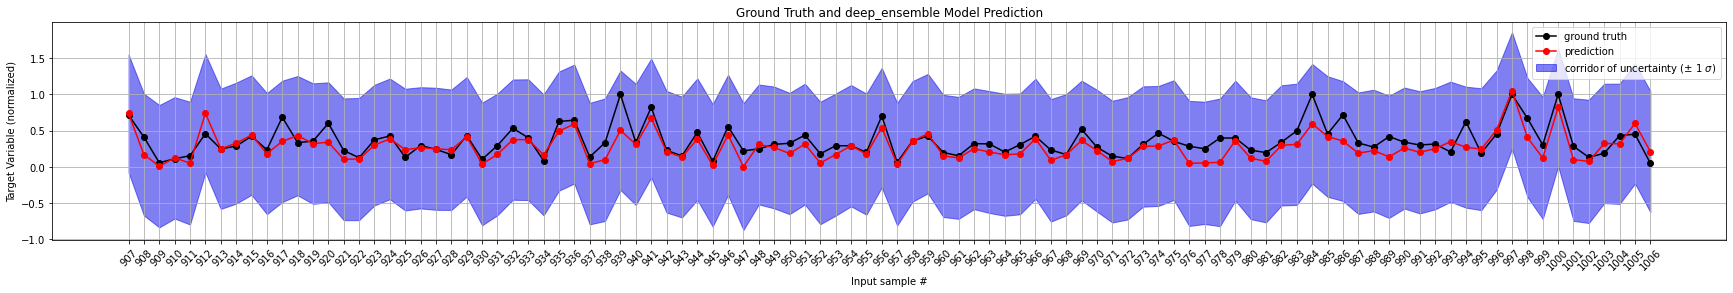

In [ ]:
start_index = np.random.randint(test_data.shape[0]-150)
print(start_index)

random = range(start_index, start_index+100)

print(random)

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
print(test_labels_plot)
mean_dropout_plot = np.asarray([float(pred_mean[i]) for i in random])
std_dropout_plot = np.asarray([float(pred_std[i]) for i in random])

print(np.unique(std_dropout_plot))

plot(test_labels_plot, mean_dropout_plot, std_dropout_plot, path+'output_plots/'+uncert_name+'_vs_prediction.pdf', random, uncert_name)

## Compute GBP explanation

In [ ]:
def gbp_explanation(model_fun, test_input, num_samples_explanations_to_be_generated, sample_id, trained_model):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [trained_model.input],    
                                     outputs = [trained_model.output])
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    feature_weight_list = [] 
    
    
    print('Example to be explained : ' , test_input)
    with tf.GradientTape() as tape:
        inputs = tf.cast(test_input, tf.float32)
        tape.watch(inputs)
        # NO NEED TO RUN THIS (the if condition) AS VISUALIZATION OF ENSEMBLE HEATMAPS FOR INNER LAYER WOULD MAKE NO SENSE : FILTER IN EVERY INDIVIDUAL ENSEMBLE UNIT WOULD LEARN SOMETHING DIFFERENT EVERYTIMG
        # THIS THESIS NEEDS TO FOCUS ON FINAL LAYER HEATMAPS (AS THEY SHOULD BE SAME FOR A GIVEN INPUT ACROSS ENSEMBLES)
                
        #outputs = gb_model.predict(inputs) 

        outputs = gb_model(inputs)
        print(outputs)
        print('outputs ', outputs) 

        output_mean = outputs[0][0]    #essentially it is a list of lists (inner list has the format : (pred_mean, pred_variance))
        output_var = outputs[0][1]
        # essentially model() and model.predict() yield the same output with the difference that 
        # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
        #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
        #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()


    print('feature_names ', feature_names)
    print('outputs mean ', output_mean)
    print('outputs var ', output_var)

    grads = tape.gradient(output_mean, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
    print('grads \n', grads)

    grads = grads.numpy() #as the model(inputs) returns a tensor and this is eventually used in the gradient computation, for plotting purpose this needs to be converted in np

        # normalizing the value of computed gradient for each feature [04032022 update : no need to normalize the gradients as it is only useful for visualization in heatmap ]
        # in bar charts, the gradients can remain negative 
        #grads -= np.min(grads)
        #grads /= np.max(grads)
    
    #print('normalized_grads : ', grads)
    feature_weight_list.append(grads)
    plot_explanation(grads_plot=grads, 
                     feature_names=feature_names,
                     sample_number=i, 
                     err=None, 
                     save_file_path=path+'output_plots/explanation_for_sample_number_'+str(i)+'_input_id_'+str(sample_id))   

    print('feature_weight_list : \n', feature_weight_list)
    feature_weight_arr =  np.asarray(feature_weight_list)
    print('feature_weight_arr : \n' , feature_weight_arr)
    #feature_weight = np.reshape(feature_weight_arr, (num_samples_explanations_to_be_generated, -1))
    # the mean and the std of the different explanations of the samples is computed here 
    #mean_feature_weight = np.mean(feature_weight_arr, axis=0)
    #std_feature_weight = np.std(feature_weight_arr, axis=0)

    #print(mean_feature_weight)
    #print(std_feature_weight)

    print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
    #return mean_feature_weight, std_feature_weight
    return feature_weight_arr, output_mean, output_var, grads

In [ ]:

# Analysis of the input 
test_sample_index=np.random.randint(3000)
test_input_temp = test_data[test_sample_index]
test_input = np.expand_dims(test_input_temp, axis=0)
print('test_input shape :', test_input.shape)

ground_truth = test_labels[test_sample_index]
print('test_label : ', ground_truth)

#ensemble_model.summary()

test_input shape : (1, 8)
test_label :  [0.45444931]


Example to be explained :  [[0.63157895 0.16559829 0.68627451 0.07134411 0.08916374 0.07619447
  0.08319805 0.15625302]]
[[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.23945297]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.72031003]], dtype=float32)>]]
outputs  [[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.23945297]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.72031003]], dtype=float32)>]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs mean  tf.Tensor([[0.23945297]], shape=(1, 1), dtype=float32)
outputs var  tf.Tensor([[0.72031003]], shape=(1, 1), dtype=float32)
grads 
 tf.Tensor(
[-0.29380795 -0.04628514  0.6710459  -0.20181161  0.2975474  -0.9392866
  0.14621413  0.46030134], shape=(8,), dtype=float32)
feature_weight_list : 
 [array([-0.29380795, -0.04628514,  0.6710459 , -0.2

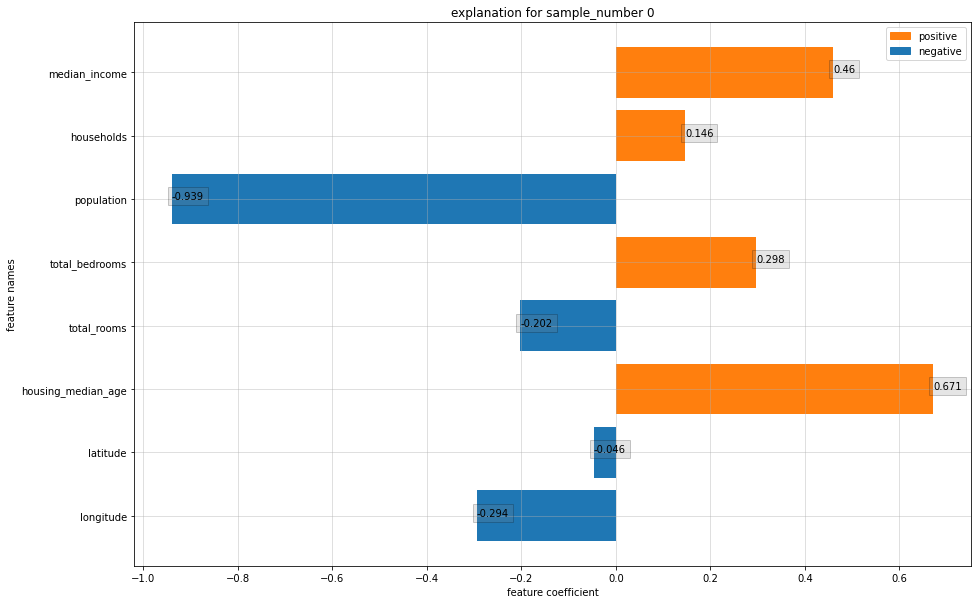

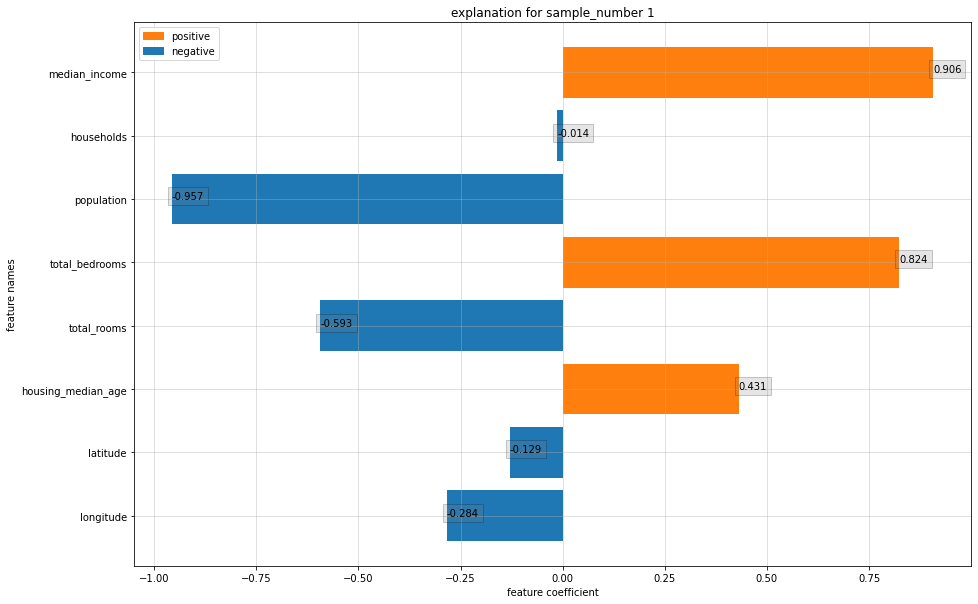

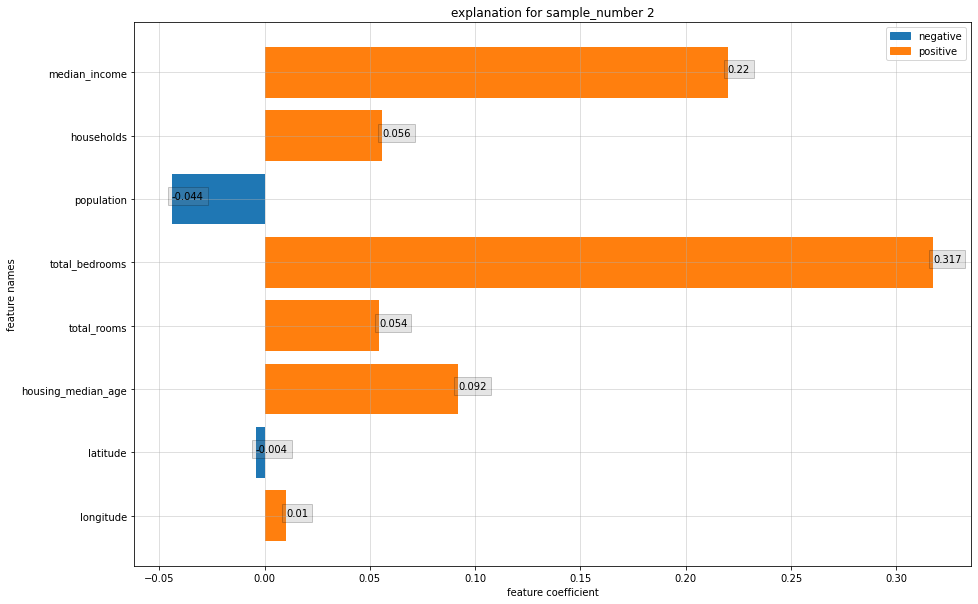

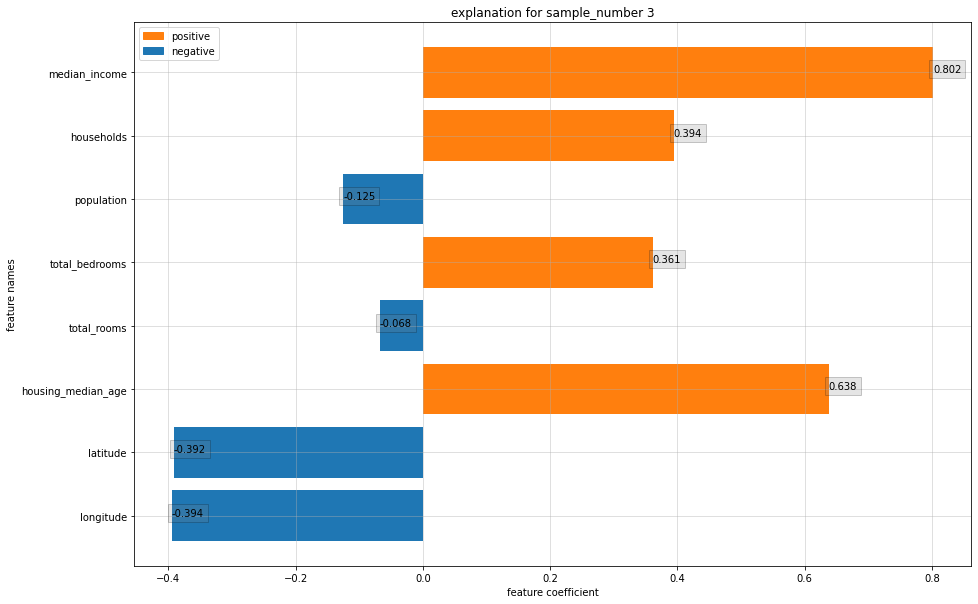

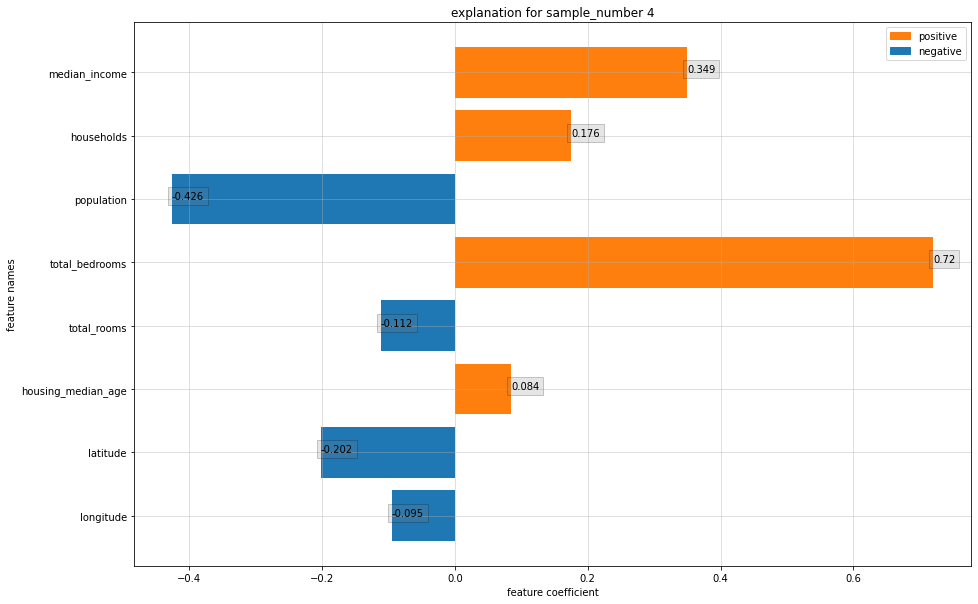

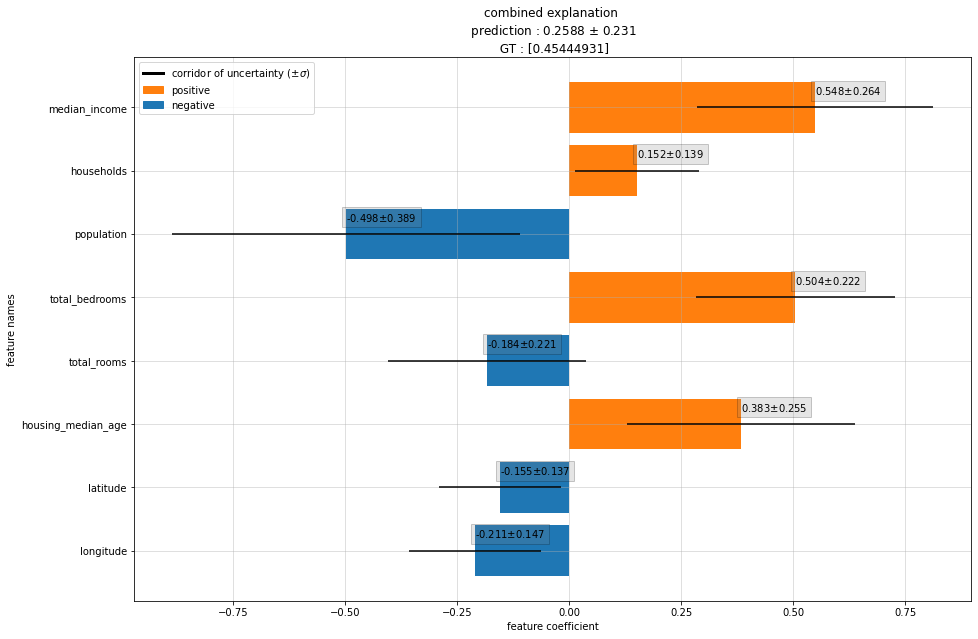

In [ ]:
grads_list, mean_feature_weight_for_all_estimators, std_feature_weight_for_all_estimators = [], [], []
output_mean, output_var = [], [] 
feature_weight_list_for_all_estimators = [] 


# looping over the ensemble components
for i in range(num_estimators):

    grads_list, output_mean_for_one_estimator, output_var_for_one_estimator, grads = gbp_explanation(model_function, 
                                               test_input, 
                                               num_samples_explanations_to_be_generated=len(model),
                                               sample_id=test_sample_index,
                                               trained_model=model[i])
    
    feature_weight_list_for_all_estimators.append(grads_list)    
    output_mean.append(output_mean_for_one_estimator)
    output_var.append(output_var_for_one_estimator)

 
feature_weight_list_for_all_estimators = np.array(feature_weight_list_for_all_estimators)
#print('mean feature weight : \n ', np.array(mean_feature_weight_for_all_estimators))
#print('std feature weight : \n ', np.array(std_feature_weight_for_all_estimators))

mean_feature_weight_for_all_estimators = np.mean(feature_weight_list_for_all_estimators, axis=0)
std_feature_weight_for_all_estimators = np.std(feature_weight_list_for_all_estimators, axis=0)

print('mean feature weight : \n', mean_feature_weight_for_all_estimators)
print('std feature weight : \n', std_feature_weight_for_all_estimators )

print('mean feature weight shape : \n', mean_feature_weight_for_all_estimators.shape)
print('std feature weight shape : \n', std_feature_weight_for_all_estimators.shape)

print('feature_weight_list_for_all_estimators \n', feature_weight_list_for_all_estimators)

print('ground_truth ', ground_truth)
mean_output = np.mean(output_mean)
var_output = np.std(output_var) 
std_output = np.sqrt(var_output)

mean_output = str(round(mean_output, 4))
std_output = str(round(std_output, 4))

print('mean_output ', mean_output)
print('var_output ', var_output)
print('std_output ', std_output)

plot_explanation(grads_plot=mean_feature_weight_for_all_estimators.squeeze(axis=0), 
                 feature_names=feature_names,
                 sample_number=None, 
                 err=std_feature_weight_for_all_estimators.squeeze(axis=0),
                 save_file_path=path+'output_plots/combined_explanation_of_'+str(len(model))+'_samples_for_input_id_'+str(test_sample_index),
                 combination_title=[mean_output, std_output, ground_truth])
    

In [ ]:
#print(feature_weight_list_for_all_estimators.shape)

#histo = feature_weight_list_for_all_estimators.squeeze(axis=1)
#print(histo.shape)
#for i in range(8):
#    plt.hist(histo[:,i])
#    plt.show()

## Coefficient of Variation

mean_feature_weight  [[-0.21135747 -0.15477924  0.3832389  -0.18398266  0.50400966 -0.49823618
   0.15164201  0.54754746]]
std_feature_weight  [[0.14698175 0.13673978 0.25466862 0.22051331 0.22229725 0.38864422
  0.13850263 0.26361808]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
coefficient_of_variation  [-69.54177618026733, -88.34503293037415, 66.45166277885437, -119.85548734664917, 44.10575032234192, -78.00401449203491, 91.33526086807251, 48.145246505737305]


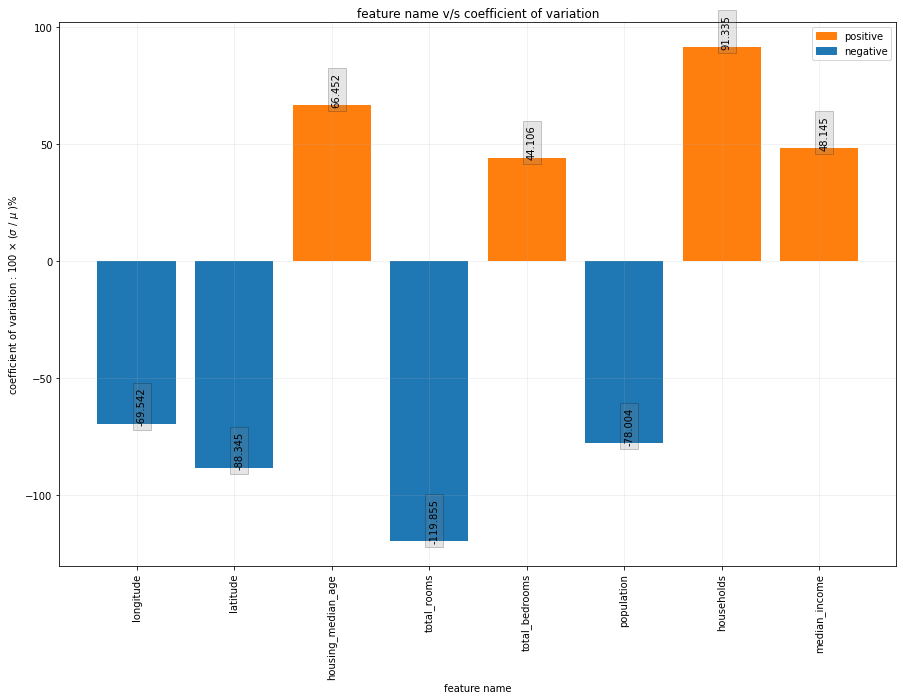

In [ ]:
# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) 
# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]
# https://en.wikipedia.org/wiki/Coefficient_of_variation
# https://www.formpl.us/blog/coefficient-variation

print('mean_feature_weight ', mean_feature_weight_for_all_estimators)
print('std_feature_weight ', std_feature_weight_for_all_estimators)
print('feature_names ', feature_names)

list_mean_feature_weight_for_all_estimators = np.squeeze(mean_feature_weight_for_all_estimators, axis=0)
list_std_feature_weight_for_all_estimators = np.squeeze(std_feature_weight_for_all_estimators, axis=0)

eps=1e-3
# compute coefficient of variation 
coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(list_std_feature_weight_for_all_estimators, list_mean_feature_weight_for_all_estimators)]
print('coefficient_of_variation ', coefficient_of_variation)

plt.figure(figsize=(15, 10))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label

plt.bar(feature_names[:-1], coefficient_of_variation, color=colors)
# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : 100 $\times$ ($\sigma$ / $\mu$ )%')
plt.grid(alpha=0.2) 


plt.legend(handles, labels)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i, v, str(round(v, 3)), rotation=90, Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.pdf', bbox_inches='tight')

#https://en.wikipedia.org/wiki/Kurtosis